### Importing dependencies

In [67]:
import os
import random
import sys
import glob
import tensorflow as tf
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import time
import ipywidgets as widgets
from IPython.display import display
from ipywidgets.widgets import Output
from factor_analyzer import FactorAnalyzer

os.chdir(r'C:\Users\sriva\Desktop\edu.usf.sas.pal.muser\SpeechAnalysis')
%matplotlib inline

### Data Import and Processing

In [2]:
data_dir = os.listdir('Speech data')
data_dir.sort()
print(data_dir)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


##### Processing the data into dataframe

In [3]:
speech_data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender', 'intensity', 'statement', 'repitition', 'emotion'])

index = 0
for sub_dir in data_dir:
    list_of_files = os.listdir('Speech data/'+sub_dir)
    print('Accessing data in', sub_dir)
    for file in list_of_files:
        file_features = file.split('.')[0].split('-')
        path = 'Speech data/' + sub_dir + '/' + file
        source = file_features[0]
        actor = file_features[-1]
        emotion = file_features[2]
        
        if int(actor) % 2 == 0:
            gender = 'female'
        else:
            gender = 'male'
        
        if file_features[3] == '01':
            intensity = 'normal'
        else:
            intensity = 'strong'
        
        if file_features[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if file_features[5] == '01':
            repeat = 0
        else:
            repeat = 1
        speech_data_df.loc[index] = [path, source, actor, gender, intensity, statement, repeat, emotion]
        index += 1
    print('Data extracted from', sub_dir)

Accessing data in Actor_01
Data extracted from Actor_01
Accessing data in Actor_02
Data extracted from Actor_02
Accessing data in Actor_03
Data extracted from Actor_03
Accessing data in Actor_04
Data extracted from Actor_04
Accessing data in Actor_05
Data extracted from Actor_05
Accessing data in Actor_06
Data extracted from Actor_06
Accessing data in Actor_07
Data extracted from Actor_07
Accessing data in Actor_08
Data extracted from Actor_08
Accessing data in Actor_09
Data extracted from Actor_09
Accessing data in Actor_10
Data extracted from Actor_10
Accessing data in Actor_11
Data extracted from Actor_11
Accessing data in Actor_12
Data extracted from Actor_12
Accessing data in Actor_13
Data extracted from Actor_13
Accessing data in Actor_14
Data extracted from Actor_14
Accessing data in Actor_15
Data extracted from Actor_15
Accessing data in Actor_16
Data extracted from Actor_16
Accessing data in Actor_17
Data extracted from Actor_17
Accessing data in Actor_18
Data extracted from A

In [4]:
speech_data_df.shape

(1440, 8)

In [5]:
speech_data_df.head()

,path,source,actor,gender,intensity,statement,repitition,emotion
0,Speech data/Actor_01/03-01-01-01-01-01-01.wav,03,01,male,normal,0,0,01
1,Speech data/Actor_01/03-01-01-01-01-02-01.wav,03,01,male,normal,0,1,01
2,Speech data/Actor_01/03-01-01-01-02-01-01.wav,03,01,male,normal,1,0,01
3,Speech data/Actor_01/03-01-01-01-02-02-01.wav,03,01,male,normal,1,1,01
4,Speech data/Actor_01/03-01-02-01-01-01-01.wav,03,01,male,normal,0,0,02


### Sample Audio Analysis

##### Sample data for EDA

In [6]:
sample_file = speech_data_df['path'][np.random.randint(len(speech_data_df))]
print(sample_file)

Speech data/Actor_24/03-01-03-01-02-02-24.wav


In [7]:
ipd.Audio(sample_file)

In [8]:
sample_data, sample_rate = librosa.load(sample_file)
sample_data, sample_rate

(array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 4.4829296e-05,
        4.9405139e-06, 0.0000000e+00], dtype=float32),
 22050)

##### Waveform

Waveplot is a representation of amplitude vs time. It tells us the loudness of the audio at a particular time.

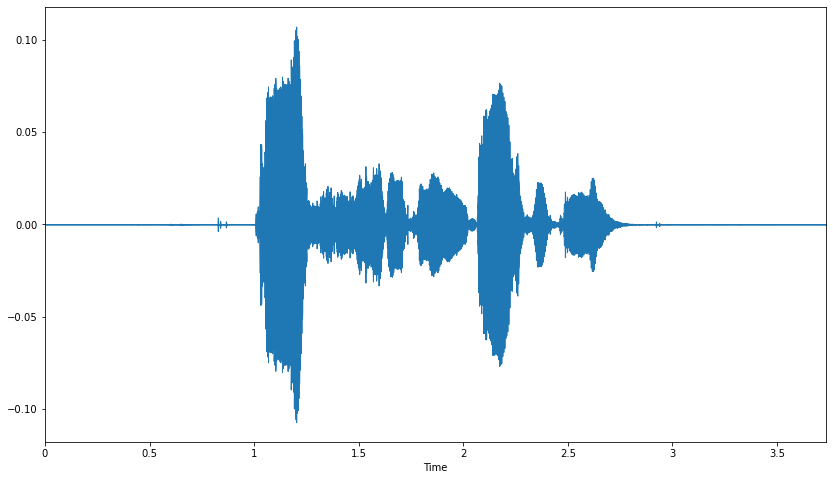

In [9]:
plt.figure(figsize=(14, 8))
fig = librosa.display.waveplot(sample_data, sr=sample_rate)

##### Spectrogram

A spectrogram is a visual representation of the spectrum of sound frequencies as they vary with time. It represents the frequencies changing with respect to time for the given audio signal.

In [10]:
X = librosa.stft(sample_data)
X

array([[ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j, ...,
         4.9472769e-04+0.0000000e+00j,  9.9528627e-04+0.0000000e+00j,
         1.9045207e-03+0.0000000e+00j],
       [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j, ...,
        -2.9412430e-04-6.1872015e-05j, -3.7511895e-04+5.4374617e-04j,
        -1.0370308e-03+3.6948622e-04j],
       [ 0.0000000e+00-0.0000000e+00j,  0.0000000e+00-0.0000000e+00j,
         0.0000000e+00-0.0000000e+00j, ...,
         1.0154325e-04+3.6408423e-04j, -2.8922036e-04-5.0252164e-04j,
        -9.2490176e-05+3.0453596e-04j],
       ...,
       [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00+0.0000000e+00j, ...,
         2.6831199e-07-1.9356219e-07j, -4.9080910e-07+3.0340749e-07j,
        -2.3063370e-05+4.0044683e-06j],
       [ 0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j,
         0.0000000e+00

.stft converts data into short term Fourier transform. STFT converts signal such that we can know the amplitude of a given frequency at a given time. Using STFT, we can determine the amplitude of various frequencies playing at a given time of an audio signal.

In [11]:
X_db = librosa.amplitude_to_db(abs(X))
X_db

array([[-54.872032, -54.872032, -54.872032, ..., -54.872032, -54.872032,
        -54.40429 ],
       [-54.872032, -54.872032, -54.872032, ..., -54.872032, -54.872032,
        -54.872032],
       [-54.872032, -54.872032, -54.872032, ..., -54.872032, -54.872032,
        -54.872032],
       ...,
       [-54.872032, -54.872032, -54.872032, ..., -54.872032, -54.872032,
        -54.872032],
       [-54.872032, -54.872032, -54.872032, ..., -54.872032, -54.872032,
        -54.872032],
       [-54.872032, -54.872032, -54.872032, ..., -54.872032, -54.872032,
        -54.872032]], dtype=float32)

The range of perceivable sound pressure is very wide, from around 20 μPa (micro Pascal) to 20 Pa, a ratio of 1 million. Furthermore the human perception of sound levels is not linear, but better approximated by a logarithm.

By converting to decibels (dB) the scale becomes logarithmic. This limits the numerical range, to something like 0-120 dB instead.

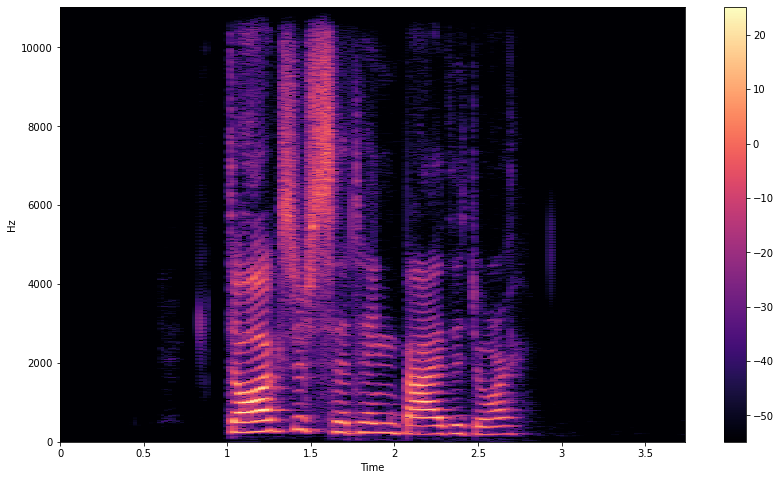

In [12]:
plt.figure(figsize=(14, 8))
librosa.display.specshow(X_db, sr=sample_rate, x_axis='time', y_axis='hz')
fig = plt.colorbar()

.specshow is used to display spectogram.

### Feature Extraction

##### Zero Crossing Rate

Zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative and vice-versa.

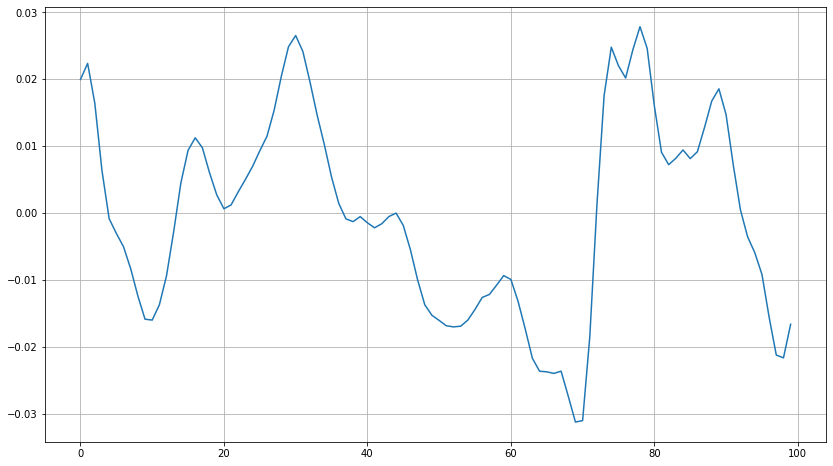

In [13]:
# Zooming in
n0 = 23000
n1 = 23100
plt.figure(figsize=(14, 8))
plt.plot(sample_data[n0:n1])
plt.grid()

By zooming in on a small array range of 100, we could observe that:
* The signal crosses zero minimum 6 times

But, let's confirm our observation using librosa's zero_crossings functionality.

In [14]:
zero_crossings = librosa.zero_crossings(sample_data[n0:n1], pad=False)
print(sum(zero_crossings))

5


Seems like we missed a few crossings in the plot, but now we have the exact number for this array spectrum. So, let's get the number for the entire audio.

In [15]:
zero_crossings = librosa.zero_crossings(sample_data, pad=False)
num_zero_crossings = sum(zero_crossings)
print(num_zero_crossings)

26144


##### Spectral Centroid

Spectral Centroid indicates where the "centre of mass" for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.
If the frequencies in the music are same throughout then spectral centroid would be around a centre and if there are high frequencies at the end of sound, the centroid would be towards its end.

In [16]:
spectral_centroids = librosa.feature.spectral_centroid(sample_data, sr=sample_rate)[0]
spectral_centroids

array([   0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        ,    0.        ,    0.        ,    0.        ,
       4074.74098177, 4075.1291115 , 3948.80873513, 3524.72078063,
       3827.05892436, 4125.92004422, 4245.56413929, 4105.46998116,
       4014.96588176, 3632.66911706, 3354.64345065, 3231.07726042,
       3114.93489352, 3197.09209066, 3380.64643355, 3662.93163199,
       3848.81746547, 4364.73485355, 3556.03642996, 3497.12699995,
       3542.51512347, 3877.75462371, 4113.99077098, 4333.3890849 ,
       4353.43883794, 4314.7422455 , 4746.16539901, 3812.72687535,
       2450.58278015, 1809.94975866, 1740.42490366, 1795.49316656,
       1928.19605903, 1959.30344525, 1963.85269155, 1867.27131691,
       1782.63891981, 1670.22545742, 1547.00786727, 1549.13556264,
       4103.96059162, 5724.77981777, 6251.92142917, 5866.34099

.spectral_centroid is used to calculate the spectral centroid for each frame. We can observe that it returns an array with columns equal to the number of frames in the sample.

In [17]:
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)
t

array([0.        , 0.02321995, 0.04643991, 0.06965986, 0.09287982,
       0.11609977, 0.13931973, 0.16253968, 0.18575964, 0.20897959,
       0.23219955, 0.2554195 , 0.27863946, 0.30185941, 0.32507937,
       0.34829932, 0.37151927, 0.39473923, 0.41795918, 0.44117914,
       0.46439909, 0.48761905, 0.510839  , 0.53405896, 0.55727891,
       0.58049887, 0.60371882, 0.62693878, 0.65015873, 0.67337868,
       0.69659864, 0.71981859, 0.74303855, 0.7662585 , 0.78947846,
       0.81269841, 0.83591837, 0.85913832, 0.88235828, 0.90557823,
       0.92879819, 0.95201814, 0.9752381 , 0.99845805, 1.021678  ,
       1.04489796, 1.06811791, 1.09133787, 1.11455782, 1.13777778,
       1.16099773, 1.18421769, 1.20743764, 1.2306576 , 1.25387755,
       1.27709751, 1.30031746, 1.32353741, 1.34675737, 1.36997732,
       1.39319728, 1.41641723, 1.43963719, 1.46285714, 1.4860771 ,
       1.50929705, 1.53251701, 1.55573696, 1.57895692, 1.60217687,
       1.62539683, 1.64861678, 1.67183673, 1.69505669, 1.71827

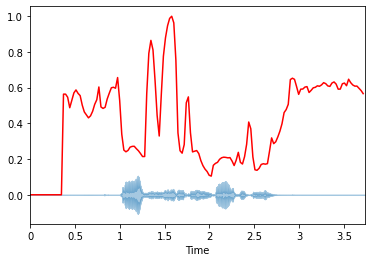

In [18]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Plotting the spectral centroid along the waveform
librosa.display.waveplot(sample_data, sr=sample_rate, alpha=0.4)
fig = plt.plot(t, normalize(spectral_centroids), color='r')

We can observe a spurious rise in the spectral centroid at the beginning of the signal. This is because the silence at the beginning has such small amplitude that high-frequency components have a chance to dominate.

##### Spectral Rolloff

Spectral Rolloff is the frequency below which a specified percentage of the total spectral energy lies, e.g. 85%.
And, similar to the Spectral Centroid, it is also calculated for each frame.

In [19]:
spectral_rolloff = librosa.feature.spectral_rolloff(sample_data, sr=sample_rate)[0]
spectral_rolloff.shape

(161,)

.spectral_rolloff is used to calculate rolloff for a given frame.

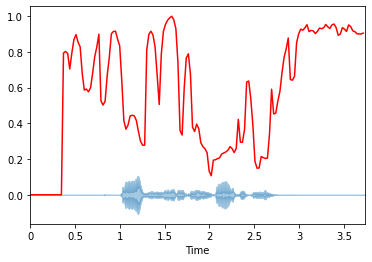

In [20]:
librosa.display.waveplot(sample_data, sr=sample_rate, alpha=0.4)
fig = plt.plot(t, normalize(spectral_rolloff), color='r')

##### MFCC - Mel-Frequency Cepstral Coefficients

MFCCs of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.

In [21]:
mfccs = librosa.feature.mfcc(sample_data, sr=sample_rate, n_mfcc=10)
mfccs.shape

(10, 161)

.mfcc is used to calculate mfccs of a signal.
The shape of MFCCs shows the number of MFCCs calculated against the number of frames.

In [22]:
mfccs

array([[-7.6944135e+02, -7.6944135e+02, -7.6944135e+02, ...,
        -7.6944135e+02, -7.6911646e+02, -7.6816223e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  4.5257387e-01,  1.6958658e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  4.3199894e-01,  1.3818671e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  1.5979339e-01, -3.4794000e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  8.3246745e-02, -2.8275287e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  4.3670703e-03, -1.0439105e-01]], dtype=float32)

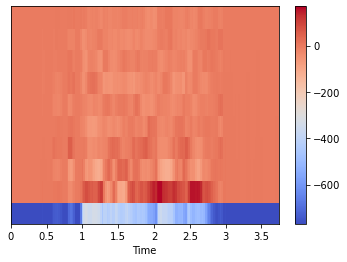

In [23]:
# Displaying the MFCCs
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
fig = plt.colorbar()

### Dataset Transformation

In [24]:
def extract_features(audio):
    sample, sr = librosa.load(audio, mono=True)
    chroma_stft = librosa.feature.chroma_stft(y=sample, sr=sr)
    rmse = librosa.feature.rms(y=sample)
    spectral_centroid = librosa.feature.spectral_centroid(y=sample, sr=sr)
    spectral_bw = librosa.feature.spectral_bandwidth(y=sample, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=sample, sr=sr)
    zc_rate = librosa.feature.zero_crossing_rate(y=sample)
    print('Features extracted for', audio)
    print(np.mean(chroma_stft), np.mean(rmse), np.mean(spectral_centroid), np.mean(spectral_bw), np.mean(rolloff), np.mean(zc_rate))
    return np.mean(chroma_stft), np.mean(rmse), np.mean(spectral_centroid), np.mean(spectral_bw), np.mean(rolloff), np.mean(zc_rate)

In [25]:
def extract_features(df):
    sample, sr = librosa.load(df['path'], mono=True)
    df['chroma_stft'] = np.mean(librosa.feature.chroma_stft(y=sample, sr=sr))
    df['rmse'] = np.mean(librosa.feature.rms(y=sample))
    df['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=sample, sr=sr))
    df['spectral_bw'] = np.mean(librosa.feature.spectral_bandwidth(y=sample, sr=sr))
    df['rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=sample, sr=sr))
    df['zc_rate'] = np.mean(librosa.feature.zero_crossing_rate(y=sample))
    return df

In [26]:
start_time = time.time()
speech_data_df = speech_data_df.apply(extract_features, axis=1)
print('Elapsed time:', time.time()-start_time)

Elapsed time: 577.4011821746826


In [27]:
speech_data_df.head()

,path,source,actor,gender,intensity,statement,repitition,emotion,chroma_stft,rmse,spectral_centroid,spectral_bw,rolloff,zc_rate
0,Speech data/Actor_01/03-01-01-01-01-01-01.wav,03,01,male,normal,0,0,01,0.598800,0.002257,3435.943088,2600.929791,6264.656291,0.326237
1,Speech data/Actor_01/03-01-01-01-01-02-01.wav,03,01,male,normal,0,1,01,0.578452,0.002420,3231.037280,2646.981271,6162.832642,0.340786
2,Speech data/Actor_01/03-01-01-01-02-01-01.wav,03,01,male,normal,1,0,01,0.587585,0.002810,3203.154528,2605.181241,6117.338659,0.356861
3,Speech data/Actor_01/03-01-01-01-02-02-01.wav,03,01,male,normal,1,1,01,0.573247,0.002618,3080.483081,2644.191743,6094.210838,0.366200
4,Speech data/Actor_01/03-01-02-01-01-01-01.wav,03,01,male,normal,0,0,02,0.561084,0.001654,3192.620354,2601.322629,6003.471105,0.313122


In [28]:
def extract_mfcc(audio):
    sample, sr = librosa.load(audio, mono=True)
    mfccs = librosa.feature.mfcc(y=sample, sr=sr, n_mfcc=10)
    list_mfcc = [np.mean(mfcc) for mfcc in mfccs]
    return np.mean(list_mfcc)

In [29]:
start_time = time.time()
speech_data_df['mfcc'] = speech_data_df['path'].map(extract_mfcc)
print('Elapsed time:', time.time()-start_time)

Elapsed time: 503.7019248008728


In [30]:
speech_data_df.head()

,path,source,actor,gender,intensity,statement,repitition,emotion,chroma_stft,rmse,spectral_centroid,spectral_bw,rolloff,zc_rate,mfcc
0,Speech data/Actor_01/03-01-01-01-01-01-01.wav,03,01,male,normal,0,0,01,0.598800,0.002257,3435.943088,2600.929791,6264.656291,0.326237,-64.160309
1,Speech data/Actor_01/03-01-01-01-01-02-01.wav,03,01,male,normal,0,1,01,0.578452,0.002420,3231.037280,2646.981271,6162.832642,0.340786,-63.382103
2,Speech data/Actor_01/03-01-01-01-02-01-01.wav,03,01,male,normal,1,0,01,0.587585,0.002810,3203.154528,2605.181241,6117.338659,0.356861,-63.452850
3,Speech data/Actor_01/03-01-01-01-02-02-01.wav,03,01,male,normal,1,1,01,0.573247,0.002618,3080.483081,2644.191743,6094.210838,0.366200,-62.512489
4,Speech data/Actor_01/03-01-02-01-01-01-01.wav,03,01,male,normal,0,0,02,0.561084,0.001654,3192.620354,2601.322629,6003.471105,0.313122,-65.782738


In [31]:
speech_data_df.to_csv('speech_data_features.csv')